# Questionaires Descriptive Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
from collections import defaultdict
from IPython.display import display
from scipy import stats
import pymc as pm
import arviz as az
import bambi as bmb
import json

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
conditions =["Large","NoAvatar", "Normal", "Small"]
questions = {
        
         1: "It felt like the virtual body was my body." ,
         2: "It felt like the virtual body parts were my body parts." ,
         3: "The virtual body felt like a human body." ,
         4 :"It felt like the virtual body belonged to me." ,
        
         5: "The movements of the virtual body felt like they were my movements." ,
         6: "I felt like I was controlling the movements of the virtual body." ,
         7: "I felt like I was causing the movements of the virtual body." ,
         8: "The movements of the virtual body were in sync with my own movements." ,
    
         9: "I felt like the form or appearance of my own body had changed." ,
         10: "I felt like the weight of my own body had changed." ,
         11: "I felt like the size (height) of my own body had changed." ,
         12: "I felt like the width of my own body had changed." ,

    }
participants = ["13","14", "15", "08", "09", "10", "11", "12","16", "17"]

demographic_labels = ["Gender", "Age", "Height", "Weight"]
vr_labels = ["VR Experience","VR Usage","First Person Video Games", "Motion Sickness"]

In [4]:
#inverted , which is needed for some of the presence quetsionaires ( 8-, since  a likert scale of 7 was used)
def invert(d):
    return 8-d

## Read data of all presence and embodiment questionaires

In [5]:
embodi_data = {}
#computer = "C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis"
computer = "C:/Users/LauflaborVR2/GS-MT_Test"
for c in conditions:
    temp = []    
    for p in participants:
             d = pd.read_csv(computer +"/data/" + p + c + ".csv", names= ["Question", "Value"])
             temp.append(d)
    embodi_data[c] = temp

In [5]:


for i, val in  enumerate(participants):
    print(len(embodi_data["Normal"][i]))

12
12
12
12
12
12
12
12
12
12


In [6]:

soci_data = pd.read_csv(computer +"/Data/main_presence_questionaire.csv")
soci_data_pilot = pd.read_csv(computer + "/Data_pilot/data_vr_walking_with_avatars_2024-07-09_16-00.csv")

In [6]:
# export height and weight data
heights = soci_data["Height"]
weights = soci_data["Weight"]
weights.to_csv("weights.csv", index= False)
heights.to_csv("heights.csv", index= False)

### Embodiment Analysis

In [7]:
#sort the data regarding their factors and conditions
small = defaultdict(list)
large =defaultdict(list)
normal = defaultdict(list)
noAvatar = defaultdict(list)
for p in range(len(participants)):
        small["Ownership"].append(embodi_data["Small"][p].loc[embodi_data["Small"][p]["Question"]<5]["Value"].sum(axis=0)/4)
        small["Agency"].append(embodi_data["Small"][p].loc[(embodi_data["Small"][p]["Question"] > 4) & (embodi_data["Small"][p]["Question"]<9) ]["Value"].sum(axis=0)/4)
        small["Change"].append(embodi_data["Small"][p].loc[embodi_data["Small"][p]["Question"]>8]["Value"].sum(axis=0)/4)
        large["Ownership"].append(embodi_data["Large"][p].loc[embodi_data["Large"][p]["Question"]<5]["Value"].sum(axis=0)/4)
        large["Agency"].append(embodi_data["Large"][p].loc[(embodi_data["Large"][p]["Question"] > 4) & (embodi_data["Large"][p]["Question"]<9) ]["Value"].sum(axis=0)/4)
        large["Change"].append(embodi_data["Large"][p].loc[embodi_data["Large"][p]["Question"]>8]["Value"].sum(axis=0)/4)
        normal["Ownership"].append(embodi_data["Normal"][p].loc[embodi_data["Normal"][p]["Question"]<5]["Value"].sum(axis=0)/4)
        normal["Agency"].append(embodi_data["Normal"][p].loc[(embodi_data["Normal"][p]["Question"] > 4) & (embodi_data["Normal"][p]["Question"]<9) ]["Value"].sum(axis=0)/4)
        normal["Change"].append(embodi_data["Normal"][p].loc[embodi_data["Normal"][p]["Question"]>8]["Value"].sum(axis=0)/4)
        noAvatar["Ownership"].append(embodi_data["NoAvatar"][p].loc[embodi_data["NoAvatar"][p]["Question"]<5]["Value"].sum(axis=0)/4)
        noAvatar["Agency"].append(embodi_data["NoAvatar"][p].loc[(embodi_data["NoAvatar"][p]["Question"] > 4) & (embodi_data["NoAvatar"][p]["Question"]<9) ]["Value"].sum(axis=0)/4)
        noAvatar["Change"].append(embodi_data["NoAvatar"][p].loc[embodi_data["NoAvatar"][p]["Question"]>8]["Value"].sum(axis=0)/4)
dicts = [noAvatar, normal, small, large ]
keys = small.keys()

In [8]:
# Schleife über die Bedingungen
for condition in conditions:
    x = embodi_data[condition]  # Extrahiere die Daten für die jeweilige Bedingung
    all_values = [df["Value"] for df in x] # Passe dies an deine tatsächliche Struktur an
    
    # Shapiro-Wilk-Test durchführen
    stat, p_value = stats.shapiro(all_values)
    
    # Ergebnisse ausgeben
    print(f"Shapiro-Wilk-Test für {condition}: Teststatistik = {stat:.4f}, p-Wert = {p_value: .9f}")
## deutet auf nicht normalverteilt hin!

Shapiro-Wilk-Test für Large: Teststatistik = 0.9143, p-Wert =  0.000001142
Shapiro-Wilk-Test für NoAvatar: Teststatistik = 0.8444, p-Wert =  0.000000001
Shapiro-Wilk-Test für Normal: Teststatistik = 0.9115, p-Wert =  0.000000799
Shapiro-Wilk-Test für Small: Teststatistik = 0.9282, p-Wert =  0.000007400


In [44]:
condition_indices = {
    "NoAvatar": 0,
    "Normal": 1,
    "Small": 2,
    "Large": 3
}
# Durchführung der Tests
comparisons = [("NoAvatar", "Normal"), ("NoAvatar", "Small"), ("NoAvatar", "Large")]

results_wilcoxon_corrected = {}

# Wilcoxon-Test für jede Dimension und jeden Vergleich

for cond1, cond2 in comparisons:
    results_wilcoxon_corrected[(cond1, cond2)] = {}
    idx1 = condition_indices[cond1]
    idx2 = condition_indices[cond2]
    for key in keys:
        stat, p_value = stats.wilcoxon(dicts[idx1][key], dicts[idx2][key])
        results_wilcoxon_corrected[(cond1, cond2)][key] = {"stat": stat, "p_value": p_value}

# Ergebnisse anzeigen
results_wilcoxon_corrected
# Durchführung der Wilcoxon-Tests zwischen den Bedingungen ohne "NoAvatar"
comparisons_without_no_avatar = [("Normal", "Small"), ("Normal", "Large"), ("Small", "Large")]

# Durchführung der Tests
results_wilcoxon_no_avatar = {}

# Wilcoxon-Test für jede Dimension und jeden Vergleich ohne "NoAvatar"
for cond1, cond2 in comparisons_without_no_avatar:
    results_wilcoxon_no_avatar[(cond1, cond2)] = {}
    idx1 = condition_indices[cond1]
    idx2 = condition_indices[cond2]
    
    for key in keys:
        stat, p_value = stats.wilcoxon(dicts[idx1][key], dicts[idx2][key])
        results_wilcoxon_no_avatar[(cond1, cond2)][key] = {"stat": stat, "p_value": p_value}

# Ergebnisse anzeigen
results_wilcoxon_no_avatar



{('Normal',
  'Small'): {'Ownership': {'stat': 13.5,
   'p_value': 0.28377195719583115}, 'Agency': {'stat': 12.0,
   'p_value': 0.3979076689546348}, 'Change': {'stat': 7.0,
   'p_value': 0.0658399776970815}},
 ('Normal',
  'Large'): {'Ownership': {'stat': 6.0,
   'p_value': 0.1747487117505534}, 'Agency': {'stat': 14.5,
   'p_value': 0.6214884480044061}, 'Change': {'stat': 0.0,
   'p_value': 0.011616044899262472}},
 ('Small',
  'Large'): {'Ownership': {'stat': 22.0,
   'p_value': 0.9523456446736592}, 'Agency': {'stat': 13.0,
   'p_value': 0.2587153167948143}, 'Change': {'stat': 19.0,
   'p_value': 0.676250572742389}}}

In [46]:
# Aggregation der Mittelwerte der Avatar-Bedingungen
avatar_combined = defaultdict(list)

# Durchschnittswerte der drei Avatar-Bedingungen berechnen
for key in keys:
    for p in range(len(dicts[0][key])):
        mean_value = np.mean([normal[key][p], small[key][p], large[key][p]])
        avatar_combined[key].append(mean_value)

# Wilcoxon-Test zwischen NoAvatar und den aggregierten Avatar-Bedingungen
results_no_avatar_vs_avatars = {}

for key in keys:
    stat, p_value = stats.wilcoxon(dicts[0][key], avatar_combined[key])
    results_no_avatar_vs_avatars[key] = {"stat": stat, "p_value": p_value}

# Ergebnisse anzeigen
results_no_avatar_vs_avatars



{'Ownership': {'stat': 19.0, 'p_value': 0.6784023758521882},
 'Agency': {'stat': 21.0, 'p_value': 0.8589549227374824},
 'Change': {'stat': 5.0, 'p_value': 0.038151710173415135}}

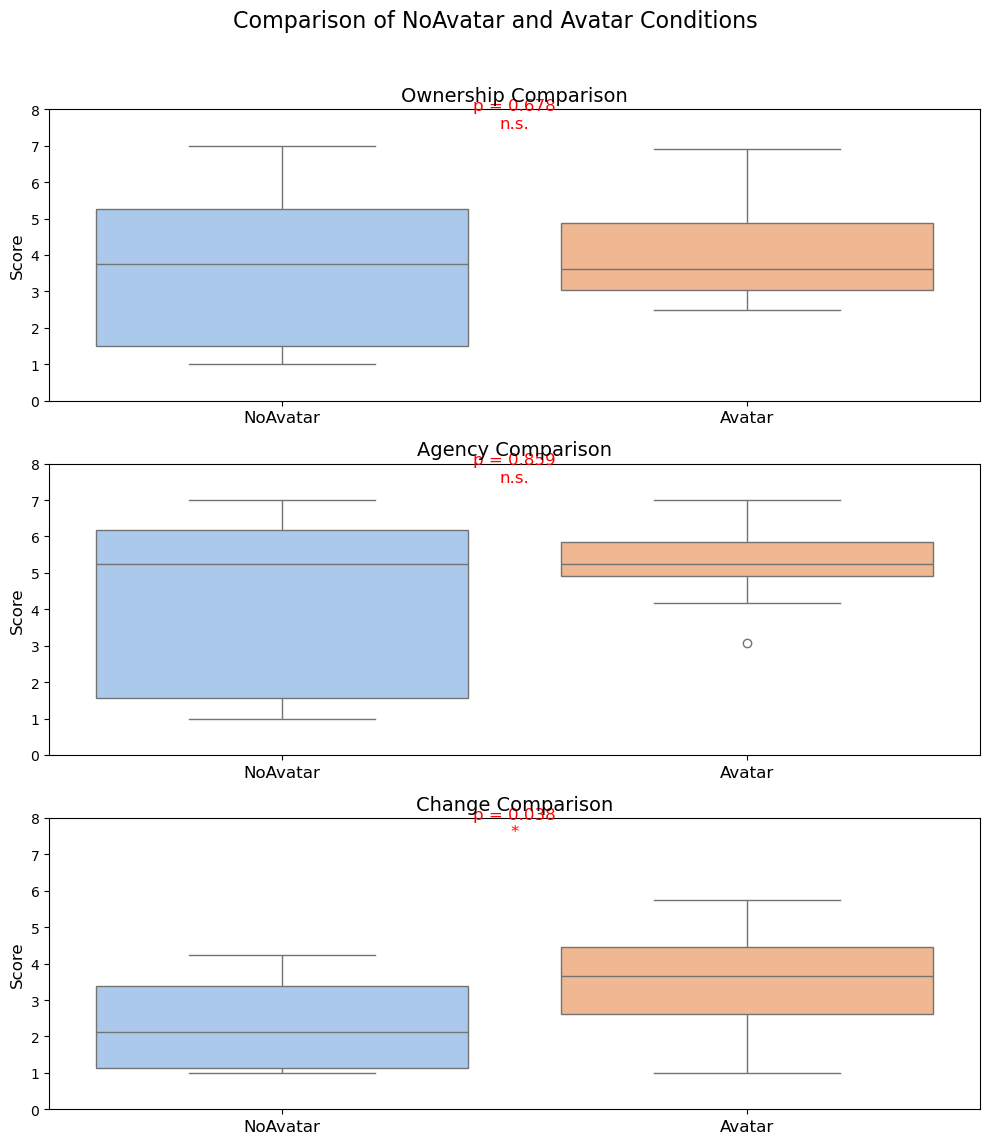

In [47]:
# Boxplot erstellen
conditions = ["NoAvatar", "Avatar"]
dimensions = ["Ownership", "Agency", "Change"]

data_for_plot = {
    "Ownership": [dicts[0]["Ownership"], avatar_combined["Ownership"]],
    "Agency": [dicts[0]["Agency"], avatar_combined["Agency"]],
    "Change": [dicts[0]["Change"], avatar_combined["Change"]],
}

# P-Werte für Annotationen
p_values = {
    "Ownership": 0.678,
    "Agency": 0.859,
    "Change": 0.038,
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for ax, dim in zip(axes, dimensions):
    sns.boxplot(data=data_for_plot[dim], ax=ax, palette="pastel")
    ax.set_title(f'{dim} Comparison', fontsize=14)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(conditions, fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 8)

    

fig.suptitle("Comparison of NoAvatar and Avatar Conditions", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [9]:
values_list = []

for condition in embodi_data.values():
    # Extrahiere die 'Value'-Spalte jedes DataFrames in der Liste
    condition_values = [df.loc[df["Question"]>8]['Value'].mean() for df in condition]  # Annahme: Es gibt nur eine Zeile je DataFrame
    values_list.append(condition_values)
values_list

[[4.75, 3.0, 2.5, 5.0, 5.75, 1.0, 4.75, 5.75, 2.0, 5.0],
 [4.25, 3.5, 1.0, 2.25, 2.0, 1.0, 4.25, 3.0, 1.5, 1.0],
 [1.25, 2.75, 1.0, 4.25, 4.5, 1.0, 4.75, 5.0, 1.0, 2.5],
 [2.25, 4.25, 4.25, 3.0, 7.0, 1.0, 4.25, 4.5, 2.5, 4.5]]

In [10]:


# Friedman-Test
stat, p = stats.friedmanchisquare(*values_list)
print("Friedman-Test Statistik:", stat)
print("p-Wert:", p)

Friedman-Test Statistik: 10.793103448275847
p-Wert: 0.012898903044113823


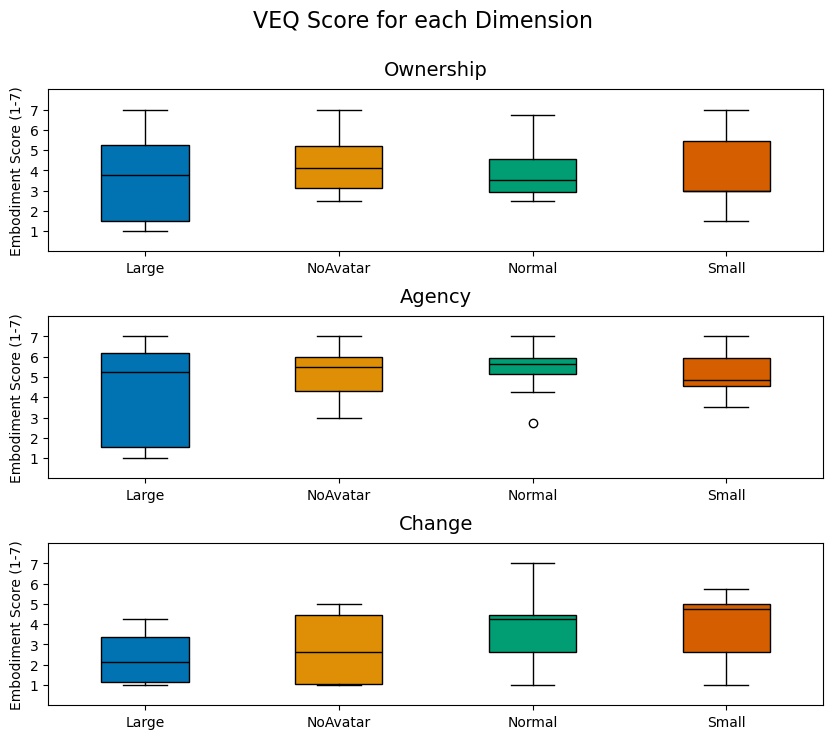

In [38]:

colors = sns.color_palette("colorblind", len(conditions))

fig, axes = plt.subplots(nrows=len(keys), ncols=1, figsize=(10, 8))
for i, key in enumerate(keys):
    # Collect data for the current key from all defaultdicts
    dat = [d[key] for d in dicts]
    # Flatten the list of lists and add a label for each defaultdict
    data_flat = [item for sublist in dat for item in sublist]
    labels = conditions
    
    # Create a boxplot
    bplot = axes[i].boxplot(dat, patch_artist = True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for mean_line in bplot['medians']:
        mean_line.set_color('black')
    axes[i].set_title(f'{key}', fontsize = 14, pad = 10)
    axes[i].set_xticklabels([conditions[j] for j in range(len(dicts))])
    axes[i].set_ylabel('Embodiment Score (1-7)', fontsize=10)
    axes[i].set_ylim(0, 8)
    axes[i].set_yticks(range(1, 8))  # Nur Ticks von 1 bis 7 anzeigen


# Set overall title and show plot
fig.subplots_adjust(hspace=0.4)
fig.suptitle('VEQ Score for each Dimension', fontsize=16)

plt.show()

### Presence Analysis

In [55]:
demo_data = soci_data[demographic_labels]
vr_data = soci_data[vr_labels]
ipq_data = soci_data.drop(demographic_labels + vr_labels, axis= 1)
vr_data_pilot = soci_data_pilot[vr_labels]
ipq_data_pilot = soci_data_pilot.drop(demographic_labels + vr_labels, axis = 1)


In [57]:
numeric_summary = demo_data.describe().loc[["mean", "std"]]
categorical_summary = demo_data.select_dtypes(include=['object']).apply(pd.Series.value_counts)
display(numeric_summary)

,Gender,Age,Height,Weight
mean,1.0,24.600000,182.300000,76.300000
std,0.0,4.376706,5.498485,12.763228


In [58]:
ipq11 = ipq_data.drop( "VPID", axis=1)
ipq11[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]]= ipq11[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]].map(invert)
display(ipq11.describe().loc[["mean", "std"]].mean(axis=1))


mean    4.042857
std     1.351169
dtype: float64

In [59]:
stat, p_value = stats.shapiro(ipq11)
print (stat, p_value)

0.926805097569457 1.2679168256314268e-06


In [66]:
# Mittelwert für jede Dimension für Gruppe 1 berechnen
mean_general_presence_group1 = ipq11.iloc[:, general_presence_questions].mean().mean()
mean_spatial_presence_group1 = ipq11.iloc[:, spatial_presence_questions].mean().mean()
mean_involvement_group1 = ipq11.iloc[:, involvement_questions].mean().mean()
mean_experienced_realism_group1 = ipq11.iloc[:, experienced_realism_questions].mean().mean()

# Gesamtmittelwert über alle Fragen für Gruppe 1 berechnen
overall_mean_group1 = ipq11.mean().mean()

# Ausgabe der Mittelwerte
print(f"Gruppe 1 - General Presence Mittelwert: {mean_general_presence_group1}")
print(f"Gruppe 1 - Spatial Presence Mittelwert: {mean_spatial_presence_group1}")
print(f"Gruppe 1 - Involvement Mittelwert: {mean_involvement_group1}")
print(f"Gruppe 1 - Experienced Realism Mittelwert: {mean_experienced_realism_group1}")
print(f"Gruppe 1 - Gesamtmittelwert über alle Fragen: {overall_mean_group1}")

Gruppe 1 - General Presence Mittelwert: 4.8
Gruppe 1 - Spatial Presence Mittelwert: 4.279999999999999
Gruppe 1 - Involvement Mittelwert: 4.1
Gruppe 1 - Experienced Realism Mittelwert: 3.5
Gruppe 1 - Gesamtmittelwert über alle Fragen: 4.042857142857143


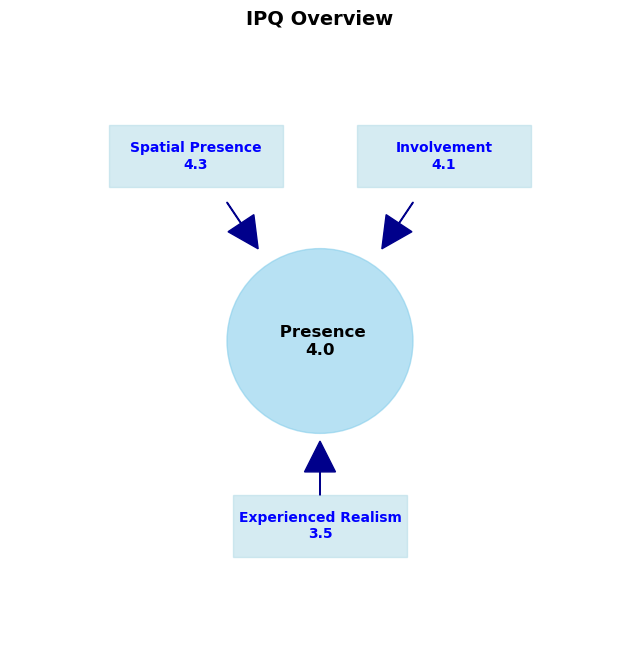

In [67]:

fig, ax = plt.subplots(figsize=(8, 8))

# Zentrale Komponente

circle = plt.Circle((0.5, 0.5), 0.15, color='skyblue', alpha=0.6)
ax.add_artist(circle)
ax.text(0.5, 0.5, f" Presence\n{overall_mean_group1:.1f}", color='black', ha='center', va='center', fontsize=12, fontweight='bold')

# Dimensionen und Werte
dimensions = ['Spatial Presence', 'Involvement', 'Experienced Realism']
values = [mean_spatial_presence_group1, mean_involvement_group1, mean_experienced_realism_group1]
positions = [(0.3, 0.8), (0.7, 0.8), (0.5, 0.2)]
arrow_positions = [(0.35, 0.725), (0.65, 0.725), (0.5, 0.25)]

# Dimensionen zeichnen
for dim, val, pos, arrow_pos in zip(dimensions, values, positions, arrow_positions):
    ax.text(pos[0], pos[1], f"{dim}\n{val:.1f}", color='blue', 
            ha='center', va='center', fontsize=10, fontweight='bold')
    rect = plt.Rectangle((pos[0]-0.14, pos[1]-0.05), 0.28, 0.1, color='lightblue', alpha=0.5)
    ax.add_artist(rect)
    ax.arrow(arrow_pos[0], arrow_pos[1], 0.15 * (0.5 - arrow_pos[0]), 0.15 * (0.5 - arrow_pos[1]), 
             head_width=0.05, head_length=0.05, fc='darkblue', ec='darkblue')


# Achsen ausschalten
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
# Diagramm anzeigen
plt.title("IPQ Overview", fontsize=14, fontweight='bold')
plt.show()

In [62]:
#Vergelich mit pilot
ipq_data_pilot = ipq_data_pilot.drop("VPID", axis = 1)
ipq_data_pilot[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]]= ipq_data_pilot[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]].map(invert)



In [63]:
for question in range(14):
    # Extrahiere die Daten der aktuellen Frage für beide Gruppen
    data_group1 = ipq11.iloc[:, question]
    data_group2 = ipq_data_pilot.iloc[:, question]
    
    # Führe den Mann-Whitney-U-Test durch
    stat, p_value = stats.mannwhitneyu(data_group1, data_group2, alternative='two-sided')
    
    # Ausgabe der Ergebnisse
    print(f'Frage {question + 1}: U-Statistik = {stat}, p-Wert = {p_value}')

Frage 1: U-Statistik = 59.5, p-Wert = 0.7639597709373778
Frage 2: U-Statistik = 46.5, p-Wert = 0.5500337118401
Frage 3: U-Statistik = 61.5, p-Wert = 0.6644482655178297
Frage 4: U-Statistik = 65.0, p-Wert = 0.4211445712786326
Frage 5: U-Statistik = 46.5, p-Wert = 0.5588108613808285
Frage 6: U-Statistik = 41.5, p-Wert = 0.3200055690728437
Frage 7: U-Statistik = 43.5, p-Wert = 0.4261435995846685
Frage 8: U-Statistik = 45.5, p-Wert = 0.5196566526238119
Frage 9: U-Statistik = 41.5, p-Wert = 0.3076442094042482
Frage 10: U-Statistik = 61.5, p-Wert = 0.6666897084445564
Frage 11: U-Statistik = 70.0, p-Wert = 0.27547222722488385
Frage 12: U-Statistik = 73.0, p-Wert = 0.20174292197986143
Frage 13: U-Statistik = 19.5, p-Wert = 0.01056492854894113
Frage 14: U-Statistik = 61.0, p-Wert = 0.682549445465888


In [64]:
# Frage 13 hat den Index 12 (da der Index bei 0 beginnt)
question_13_index = 12

# Median und Mittelwert für Frage 13 berechnen
median_group1_q13 = ipq11.iloc[:, question_13_index].median()
median_group2_q13 = ipq_data_pilot.iloc[:, question_13_index].median()

mean_group1_q13 = ipq11.iloc[:, question_13_index].mean()
mean_group2_q13 = ipq_data_pilot.iloc[:, question_13_index].mean()

# Ausgabe der Ergebnisse
print(f"Frage 13 - Median Gruppe 1: {median_group1_q13}, Median Pilotgruppe: {median_group2_q13}")
print(f"Frage 13 - Mittelwert Gruppe 1: {mean_group1_q13}, Mittelwert Pilotgruppe: {mean_group2_q13}")


Frage 13 - Median Gruppe 1: 3.0, Median Pilotgruppe: 5.0
Frage 13 - Mittelwert Gruppe 1: 3.2, Mittelwert Pilotgruppe: 4.7272727272727275


In [65]:
# Definiere die Fragen, die zu jeder Dimension gehören
general_presence_questions = [8]  # Frage 9 -> Index 8
spatial_presence_questions = [0, 1, 5, 7, 9]  # Fragen 1, 2, 6, 8, 10 -> Index 0, 1, 5, 7, 9
involvement_questions = [2, 4, 6, 13]  # Fragen 3, 5, 7, 14 -> Index 2, 4, 6, 13
experienced_realism_questions = [3, 10, 11, 12]  # Fragen 4, 11, 12, 13 -> Index 3, 10, 11, 12

# Mittelwerte für jede Dimension berechnen
group1_general_presence = ipq11.iloc[:, general_presence_questions].mean(axis=1)
group1_spatial_presence = ipq11.iloc[:, spatial_presence_questions].mean(axis=1)
group1_involvement = ipq11.iloc[:, involvement_questions].mean(axis=1)
group1_experienced_realism = ipq11.iloc[:, experienced_realism_questions].mean(axis=1)

group2_general_presence = ipq_data_pilot.iloc[:, general_presence_questions].mean(axis=1)
group2_spatial_presence = ipq_data_pilot.iloc[:, spatial_presence_questions].mean(axis=1)
group2_involvement = ipq_data_pilot.iloc[:, involvement_questions].mean(axis=1)
group2_experienced_realism = ipq_data_pilot.iloc[:, experienced_realism_questions].mean(axis=1)

# Mann-Whitney-U-Test für jede Dimension
dimensions = ['General Presence', 'Spatial Presence', 'Involvement', 'Experienced Realism']
group1_dimensions = [group1_general_presence, group1_spatial_presence, group1_involvement, group1_experienced_realism]
group2_dimensions = [group2_general_presence, group2_spatial_presence, group2_involvement, group2_experienced_realism]

for i, dimension in enumerate(dimensions):
    stat, p_value = stats.mannwhitneyu(group1_dimensions[i], group2_dimensions[i], alternative='two-sided')
    print(f'{dimension}: U-Statistik = {stat}, p-Wert = {p_value}')


General Presence: U-Statistik = 41.5, p-Wert = 0.3076442094042482
Spatial Presence: U-Statistik = 49.5, p-Wert = 0.7229530855581574
Involvement: U-Statistik = 57.5, p-Wert = 0.8867882274772534
Experienced Realism: U-Statistik = 55.5, p-Wert = 1.0


In [68]:
# Gesamtmittelwert für jeden Teilnehmer berechnen
overall_group1 = ipq11.mean(axis=1)
overall_group2 = ipq_data_pilot.mean(axis=1)

# Mann-Whitney-U-Test für den Gesamtvergleich der beiden Gruppen
stat, p_value = stats.mannwhitneyu(overall_group1, overall_group2, alternative='two-sided')

# Ausgabe der Ergebnisse
print(f'Gesamtvergleich: U-Statistik = {stat}, p-Wert = {p_value}')

# Zusätzliche Berechnung der Mediane und Mittelwerte für die beiden Gruppen
median_group1 = overall_group1.median()
median_group2 = overall_group2.median()

mean_group1 = overall_group1.mean()
mean_group2 = overall_group2.mean()

print(f"Gesamt - Median Gruppe 1: {median_group1}, Median Pilotgruppe: {median_group2}")
print(f"Gesamt - Mittelwert Gruppe 1: {mean_group1}, Mittelwert Pilotgruppe: {mean_group2}")


Gesamtvergleich: U-Statistik = 51.5, p-Wert = 0.8319892506303395
Gesamt - Median Gruppe 1: 4.071428571428571, Median Pilotgruppe: 4.0
Gesamt - Mittelwert Gruppe 1: 4.042857142857143, Mittelwert Pilotgruppe: 4.084415584415584


In [22]:
def classify_vr_experience(row):
    if row["VR Experience"] == 2:  # Keine VR-Erfahrung
        return 'No Experience'
    elif row['VR Usage'] == 1 or row['First Person Video Games'] == 1:
        return 'Expert'
    elif row['VR Usage'] in [2, 3] or row['First Person Video Games'] in [2, 3]:
        return 'Regular'
    else:
        return 'Beginner'

In [53]:
def classify_vr_experience(row):
    if row['VR Experience'] == 2:  # Keine VR-Erfahrung
        return 'No Experience'
    elif row['VR Usage'] == 1:
        return 'Expert'
    elif row['VR Usage'] in [2, 3]:
        return 'Regular'
    else:
        return 'Beginner'

In [69]:
# Neue Spalte basierend auf Klassifikation erstellen
vr_data['vr_experience'] = vr_data.apply(classify_vr_experience, axis=1)
vr_data_pilot['vr_experience'] = vr_data_pilot.apply(classify_vr_experience, axis=1)

ipq11['vr_experience'] = vr_data['vr_experience']
ipq_data_pilot['vr_experience'] = vr_data['vr_experience']


C:\Users\LauflaborVR2\AppData\Local\Temp\ipykernel_20232\3463490098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vr_data['vr_experience'] = vr_data.apply(classify_vr_experience, axis=1)
C:\Users\LauflaborVR2\AppData\Local\Temp\ipykernel_20232\3463490098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vr_data_pilot['vr_experience'] = vr_data_pilot.apply(classify_vr_experience, axis=1)


In [70]:
ipq11['General Presence'] = ipq11.iloc[:, general_presence_questions].mean(axis=1)
ipq11['Spatial Presence'] = ipq11.iloc[:, spatial_presence_questions].mean(axis=1)
ipq11['Involvement'] = ipq11.iloc[:, involvement_questions].mean(axis=1)
ipq11['Experienced Realism'] = ipq11.iloc[:, experienced_realism_questions].mean(axis=1)

ipq_data_pilot['General Presence'] = ipq_data_pilot.iloc[:, general_presence_questions].mean(axis=1)
ipq_data_pilot['Spatial Presence'] = ipq_data_pilot.iloc[:, spatial_presence_questions].mean(axis=1)
ipq_data_pilot['Involvement'] = ipq_data_pilot.iloc[:, involvement_questions].mean(axis=1)
ipq_data_pilot['Experienced Realism'] = ipq_data_pilot.iloc[:, experienced_realism_questions].mean(axis=1)

In [71]:
# Berechnung der Mean Presence
ipq11['Mean_Presence'] = ipq11[['General Presence', 'Spatial Presence', 'Involvement', 'Experienced Realism']].mean(axis=1)
ipq_data_pilot['Mean_Presence'] = ipq_data_pilot[['General Presence', 'Spatial Presence', 'Involvement', 'Experienced Realism']].mean(axis=1)

# Kombinieren der Daten für die Analyse
combined_df = pd.concat([ipq11.assign(Group='Main'), ipq_data_pilot.assign(Group='Pilot')], ignore_index=True)



In [72]:
combined_df = combined_df.drop("VPID", axis = 1)

KeyError: "['VPID'] not found in axis"

In [73]:
combined_df = combined_df.drop([20])

In [62]:
# Bayesianisches Modell mit Bambi
model = bmb.Model(
    "Mean_Presence ~ vr_experience * Group",
    combined_df,
    family="gaussian"
)
# Sampling
trace = model.fit(
    draws=2000, 
    tune= 1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, vr_experience, Group, vr_experience:Group]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 119 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


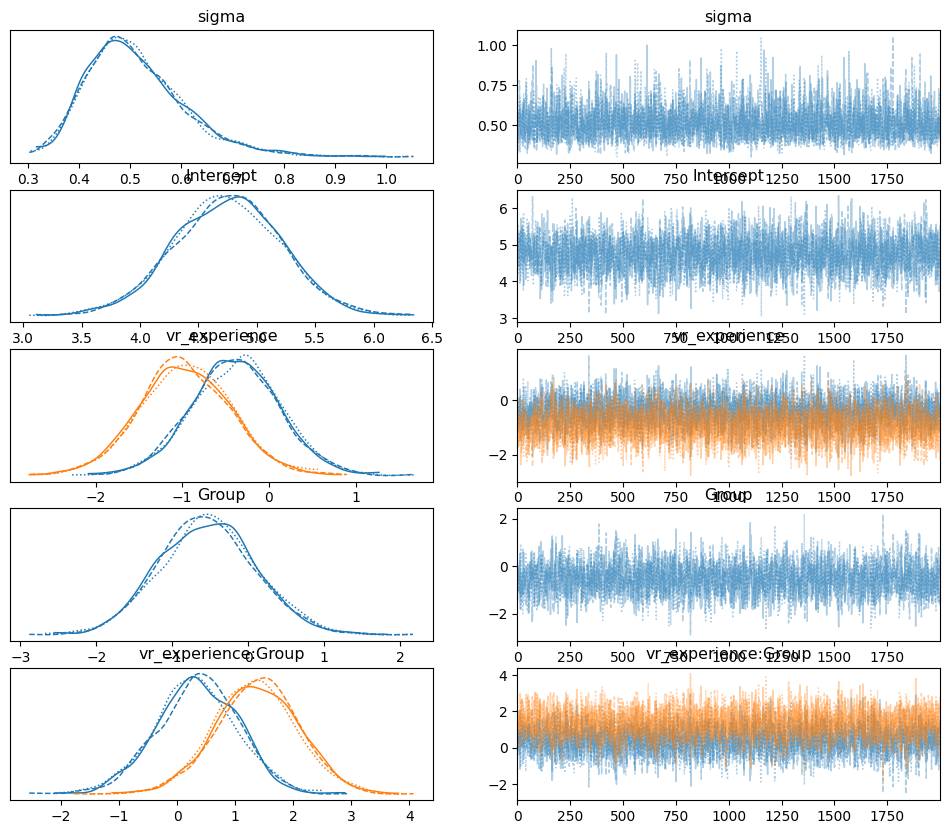

In [63]:
# Ergebnisse visualisieren
az.plot_trace(trace)
az.summary(trace, round_to=2)
plt.show()



c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


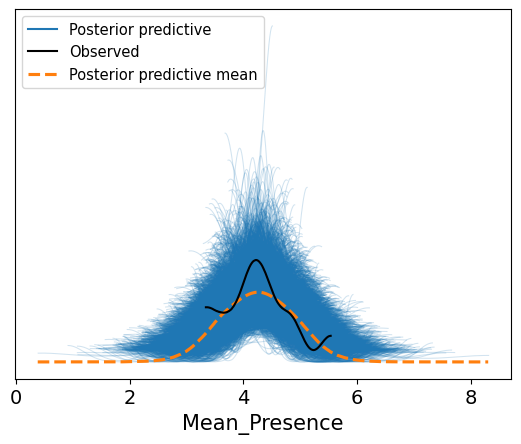

In [64]:
# Posterior Predictive Checks (PPC)
ppc = model.predict(idata=trace, kind="pps", inplace=False)
az.plot_ppc(ppc)
plt.show()

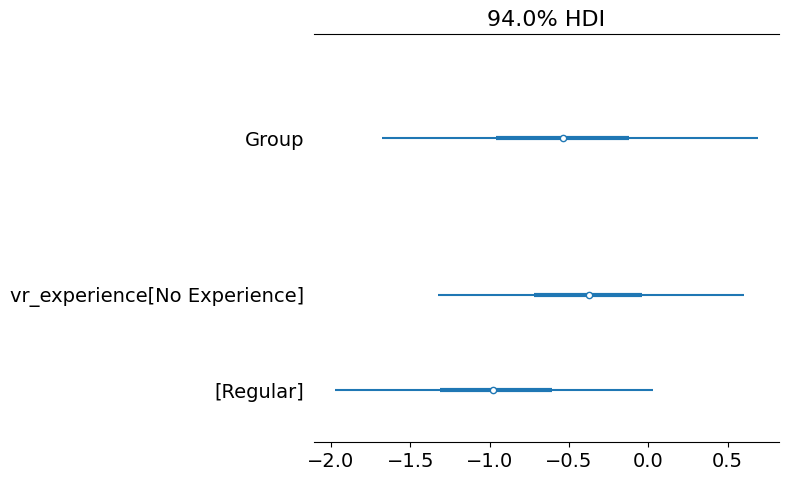

In [65]:
az.plot_forest(trace, var_names=["Group", "vr_experience"], combined=True)
plt.show()


In [67]:
# Separate Analyse für Pilotgruppe
pilot_df = combined_df[combined_df['Group'] == 'Pilot']
pilot_model = bmb.Model(
    "Mean_Presence ~ vr_experience",
    pilot_df,
    family="gaussian"
)
pilot_trace = pilot_model.fit(draws=2000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, vr_experience]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


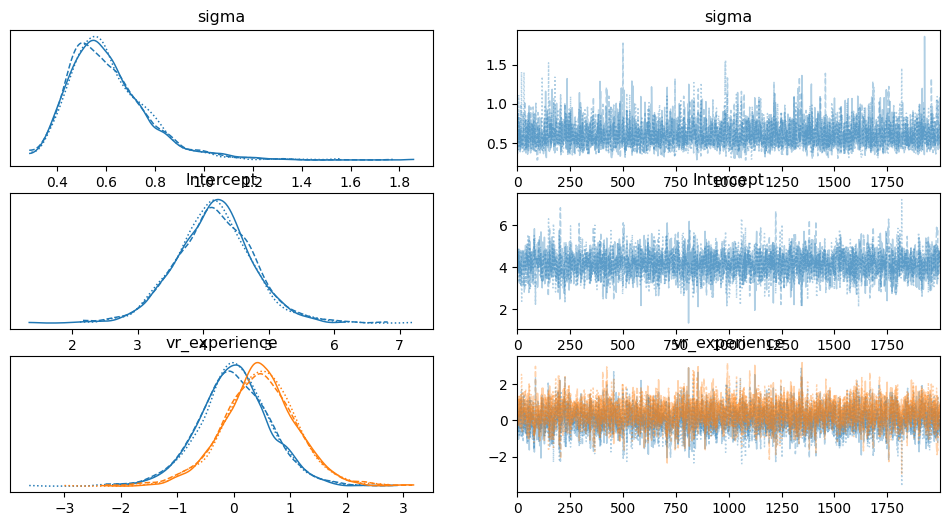

In [68]:
# Ergebnisse der Pilotgruppe visualisieren
az.plot_trace(pilot_trace)
az.summary(pilot_trace, round_to=2)
plt.show()


In [74]:

# Erstellung einer Visualisierung für die geschätzten Mittelwerte von Mean Presence
def plot_estimated_means(data, vr_experience_col="vr_experience", group_col="Group", response_col="Mean Presence"):
    """
    Visualisiert die geschätzten Mittelwerte von `response_col` (z. B. Mean Presence) 
    für unterschiedliche Gruppen und VR-Erfahrungslevel.

    Args:
    - data (DataFrame): Kombinierte Daten für Analyse.
    - vr_experience_col (str): Spaltenname der VR-Erfahrungslevel.
    - group_col (str): Spaltenname der Gruppen (z. B. Main, Pilot).
    - response_col (str): Spaltenname der Response-Variable.

    Returns:
    - Plot
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=vr_experience_col, 
        y=response_col, 
        hue=group_col, 
        data=data, 
        ci="sd", 
        palette="viridis"
    )
    plt.title("Geschätzte Mittelwerte von Presence nach VR-Erfahrung und Gruppe", fontsize=14)
    plt.ylabel("Mean Presence", fontsize=12)
    plt.xlabel("VR Erfahrung", fontsize=12)
    plt.legend(title="Gruppe")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot für geschätzte Mittelwerte
plot_estimated_means(combined_df)


C:\Users\LauflaborVR2\AppData\Local\Temp\ipykernel_20232\2531584245.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


ValueError: Could not interpret value `Mean Presence` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

## Embodiment und Erfahrung


In [75]:
# Dictionaries in DataFrames umwandeln
small_df = pd.DataFrame(small).assign(Condition='Small')
large_df = pd.DataFrame(large).assign(Condition='Large')
normal_df = pd.DataFrame(normal).assign(Condition='Normal')
noAvatar_df = pd.DataFrame(noAvatar).assign(Condition='NoAvatar')


In [76]:
all_conditions_df = pd.concat([small_df, large_df, normal_df, noAvatar_df], ignore_index=True)

In [87]:
vr_experience_repeated = list(vr_data["VR Experience"]) * 4
all_conditions_df['vr_experience'] = vr_experience_repeated

In [86]:
count_experience=all_conditions_df["vr_experience"].value_counts()
print(count_experience/4)
print(vr_data["VR Experience"].value_counts())

vr_experience
2    5.0
1    5.0
Name: count, dtype: float64
VR Experience
2    5
1    5
Name: count, dtype: int64


In [79]:
descriptive_stats = all_conditions_df.groupby(['Condition', 'vr_experience']).agg(
    Ownership_mean=('Ownership', 'mean'),
    Ownership_std=('Ownership', 'std'),
    Agency_mean=('Agency', 'mean'),
    Agency_std=('Agency', 'std'),
    Change_mean=('Change', 'mean'),
    Change_std=('Change', 'std')
).reset_index()
print("Deskriptive Statistiken:")
print(descriptive_stats)

Deskriptive Statistiken:
  Condition  vr_experience  Ownership_mean  Ownership_std  Agency_mean  \
0     Large              1            4.45       1.451293         4.95   
1     Large              2            3.50       2.061553         5.30   
2  NoAvatar              1            4.00       2.084167         4.40   
3  NoAvatar              2            3.35       2.534758         4.15   
4    Normal              1            4.45       1.123610         4.90   
5    Normal              2            4.05       1.857418         5.50   
6     Small              1            3.65       1.069462         5.00   
7     Small              2            4.05       1.604681         5.80   

   Agency_std  Change_mean  Change_std  
0    1.006231         4.85    1.126388  
1    1.303840         3.05    1.753568  
2    2.240257         2.75    1.274755  
3    2.976995         2.00    1.357848  
4    1.282088         3.90    1.180572  
5    1.131923         1.70    1.429598  
6    1.311011        

In [97]:
group1 = all_conditions_df[all_conditions_df['vr_experience'] == 1]['Ownership']
group2 = all_conditions_df[all_conditions_df['vr_experience'] == 2]['Ownership']
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney-U-Test für Ownership: U = {u_stat:.3f}, p = {p_val:.3f}")

group1 = all_conditions_df[all_conditions_df['vr_experience'] == 1]['Change']
group2 = all_conditions_df[all_conditions_df['vr_experience'] == 2]['Change']
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney-U-Test für Change: U = {u_stat:.3f}, p = {p_val:.3f}")

group1 = all_conditions_df[all_conditions_df['vr_experience'] == 1]['Agency']
group2 = all_conditions_df[all_conditions_df['vr_experience'] == 2]['Agency']
u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney-U-Test für Agency: U = {u_stat:.3f}, p = {p_val:.3f}")

effect_size = 323.5 / (len(group1) * len(group2)) 
print(f"Effektstärke r für Change: {effect_size:.3f}")

Mann-Whitney-U-Test für Ownership: U = 236.000, p = 0.335
Mann-Whitney-U-Test für Change: U = 323.500, p = 0.001
Mann-Whitney-U-Test für Agency: U = 161.500, p = 0.302
Effektstärke r für Change: 0.809


In [103]:


# Daten nach Condition und vr_experience gruppieren
groups = [
    all_conditions_df[(all_conditions_df['Condition'] == cond) & (all_conditions_df['vr_experience'] == 1)]['Change'] for cond in all_conditions_df['Condition'].unique()
]

# Kruskal-Wallis-Test
h_stat, p_val = stats.kruskal(*groups)
print(f"Kruskal-Wallis-Test für Change nach Conditions und VR-Erfahrung: H = {h_stat:.3f}, p = {p_val:.3f}")

for cond in all_conditions_df['Condition'].unique():
    group1 = all_conditions_df[(all_conditions_df['Condition'] == cond) & (all_conditions_df['vr_experience'] == 1)]['Change']
    group2 = all_conditions_df[(all_conditions_df['Condition'] == cond) & (all_conditions_df['vr_experience'] == 2)]['Change']
    
    # Prüfen, ob beide Gruppen nicht leer sind
    if len(group1) > 0 and len(group2) > 0:
        u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        print(f"Condition {cond}: Mann-Whitney-U-Test für Change: U = {u_stat:.3f}, p = {p_val:.3f}")
    else:
        print(f"Condition {cond}: Mindestens eine Gruppe ist leer.")

Kruskal-Wallis-Test für Change nach Conditions und VR-Erfahrung: H = 7.620, p = 0.055
Condition Small: Mann-Whitney-U-Test für Change: U = 24.000, p = 0.020
Condition Large: Mann-Whitney-U-Test für Change: U = 21.000, p = 0.092
Condition Normal: Mann-Whitney-U-Test für Change: U = 23.000, p = 0.034
Condition NoAvatar: Mann-Whitney-U-Test für Change: U = 16.500, p = 0.458


In [105]:
 #Effektstärken berechnen mit n1 = n2 = 5
def calculate_effect_size(u_stat, n1, n2):

    return u_stat / (n1 * n2)

n1, n2 = 5, 5

# Mann-Whitney-U-Statistiken aus den vorherigen Tests
u_small = 24.0
u_large = 21.0
u_normal = 23.0
u_noavatar = 16.5

# Effektstärken berechnen
effect_size_small = calculate_effect_size(u_small, n1, n2)
effect_size_large = calculate_effect_size(u_large, n1, n2)
effect_size_normal = calculate_effect_size(u_normal, n1, n2)
effect_size_noavatar = calculate_effect_size(u_noavatar, n1, n2)

effect_size_small, effect_size_large, effect_size_normal, effect_size_noavatar


(0.96, 0.84, 0.92, 0.66)

C:\Users\LauflaborVR2\AppData\Local\Temp\ipykernel_20232\95821771.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_conditions_df, x='vr_experience', y='Embodiment', palette='Set2')


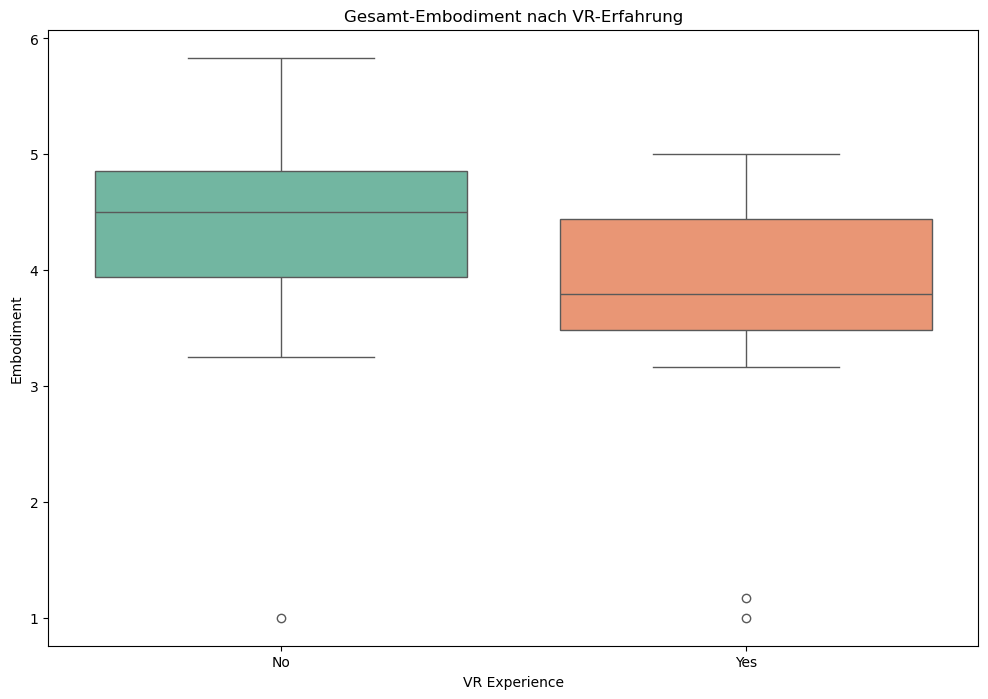

In [80]:
# Gesamt-Embodiment berechnen als Durchschnitt von Ownership, Agency und Change
all_conditions_df['Embodiment'] = all_conditions_df[['Ownership', 'Agency', 'Change']].mean(axis=1)

# Boxplot für Gesamt-Embodiment nach VR-Erfahrung
plt.figure(figsize=(12, 8))
sns.boxplot(data=all_conditions_df, x='vr_experience', y='Embodiment', palette='Set2')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.title('Gesamt-Embodiment nach VR-Erfahrung')
plt.ylabel('Embodiment')
plt.xlabel('VR Experience')
plt.show()


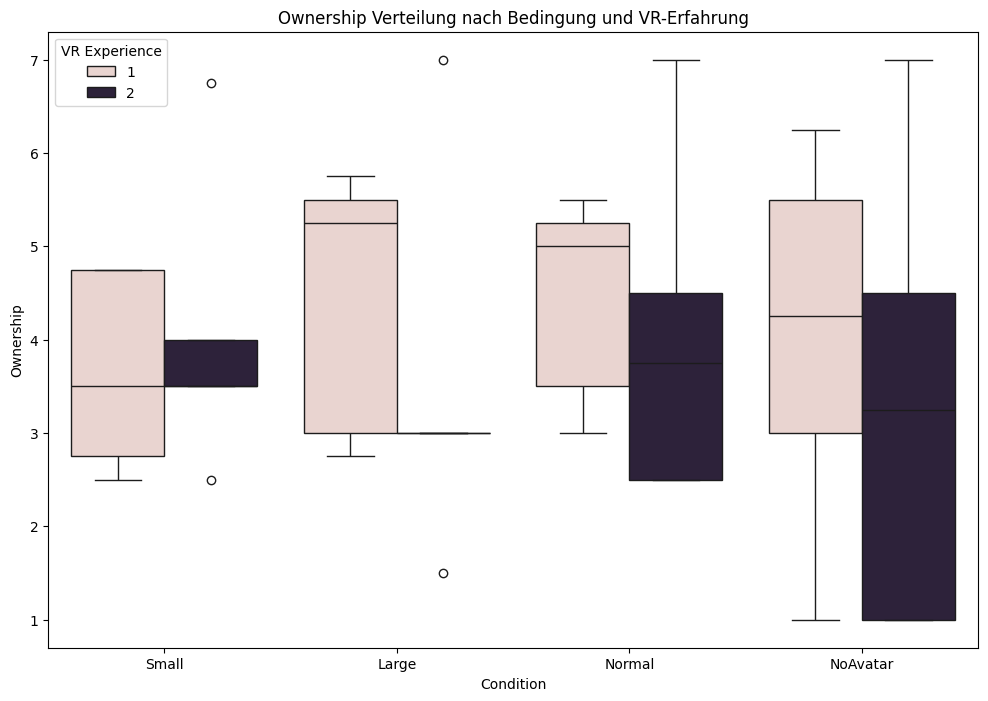

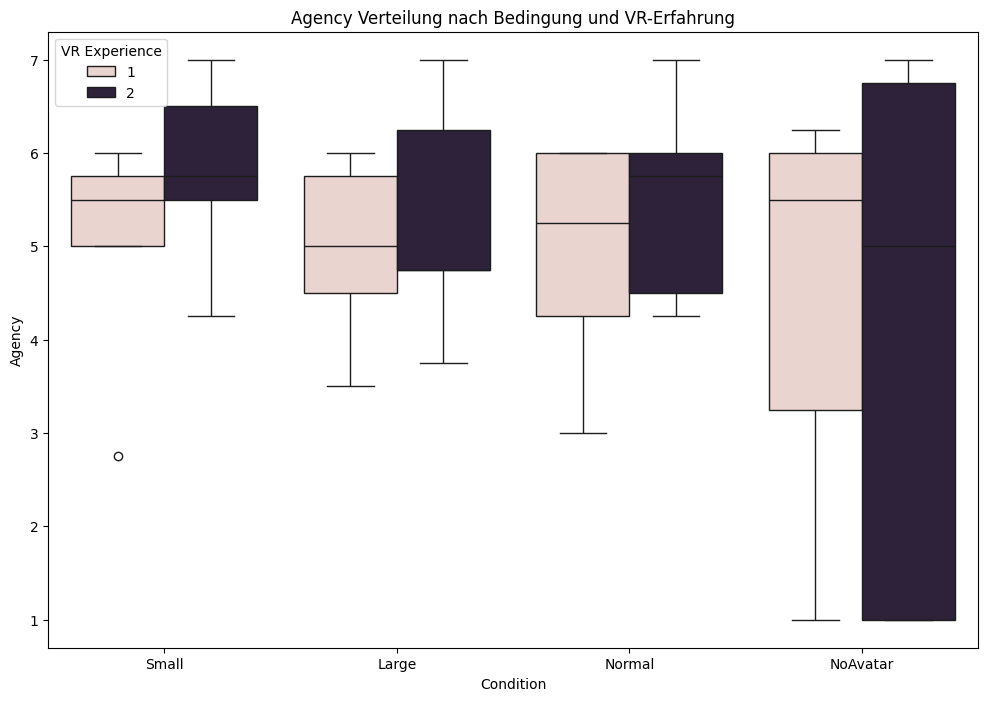

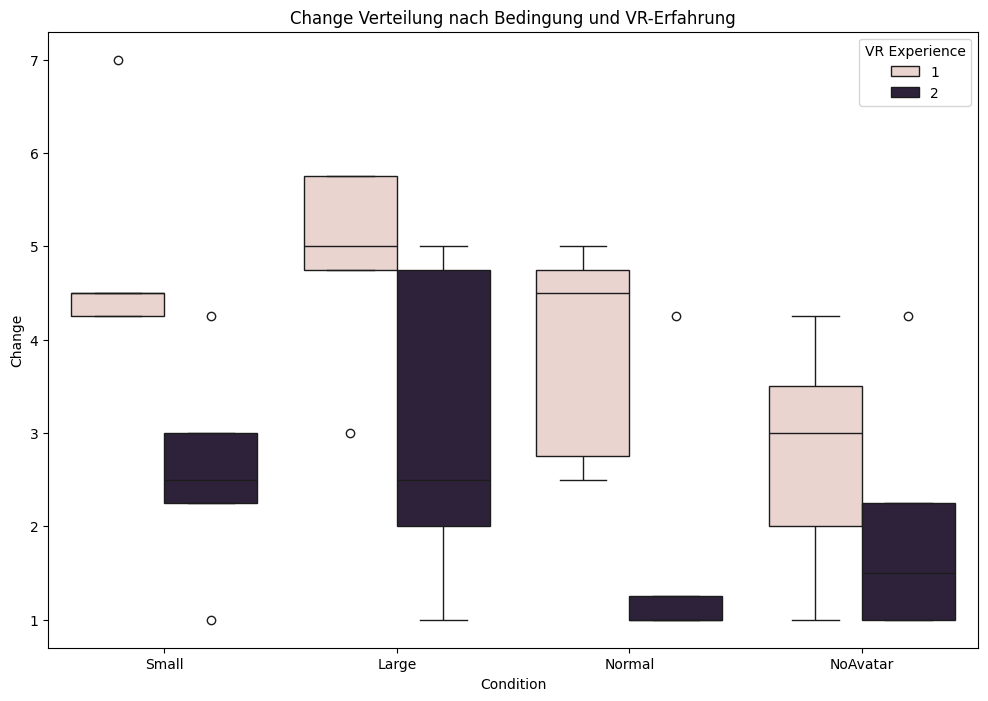

In [96]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=all_conditions_df, x='Condition', y='Ownership', hue='vr_experience')
plt.title('Ownership Verteilung nach Bedingung und VR-Erfahrung')
plt.ylabel('Ownership')
plt.xlabel('Condition')
plt.legend(title='VR Experience')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=all_conditions_df, x='Condition', y='Agency', hue='vr_experience')
plt.title('Agency Verteilung nach Bedingung und VR-Erfahrung')
plt.ylabel('Agency')
plt.xlabel('Condition')
plt.legend(title='VR Experience')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=all_conditions_df, x='Condition', y='Change', hue='vr_experience')
plt.title('Change Verteilung nach Bedingung und VR-Erfahrung')
plt.ylabel('Change')
plt.xlabel('Condition')
plt.legend(title='VR Experience')
plt.show()


In [106]:
# Bayesianisches Modell für jede Dimension separat erstellen
ownership_model = bmb.Model(
    "Ownership ~  Condition * vr_experience",
    all_conditions_df,
    family="gaussian"
)
ownership_trace = ownership_model.fit(draws=2000, tune=1000, cores = 16)

agency_model = bmb.Model(
    "Agency ~ Condition * vr_experience ",
    all_conditions_df,
    family="gaussian"
)
agency_trace = agency_model.fit(draws=2000, tune=1000, cores = 16)

change_model = bmb.Model(
    "Change ~ Condition * vr_experience",
    all_conditions_df,
    family="gaussian"
)
change_trace = change_model.fit(draws=2000, tune=1000, cores = 16)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, Intercept, Condition, vr_experience, Condition:vr_experience]


Output()

ValueError: Not enough samples to build a trace.

In [107]:
change_model = bmb.Model(
    "Change ~ Condition * vr_experience",
    all_conditions_df,
    family="gaussian"
)
change_trace = change_model.fit(draws=2000, tune=1000, cores = 16)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, Intercept, Condition, vr_experience, Condition:vr_experience]


Output()

Sampling 16 chains for 1_000 tune and 2_000 draw iterations (16_000 + 32_000 draws total) took 496 seconds.


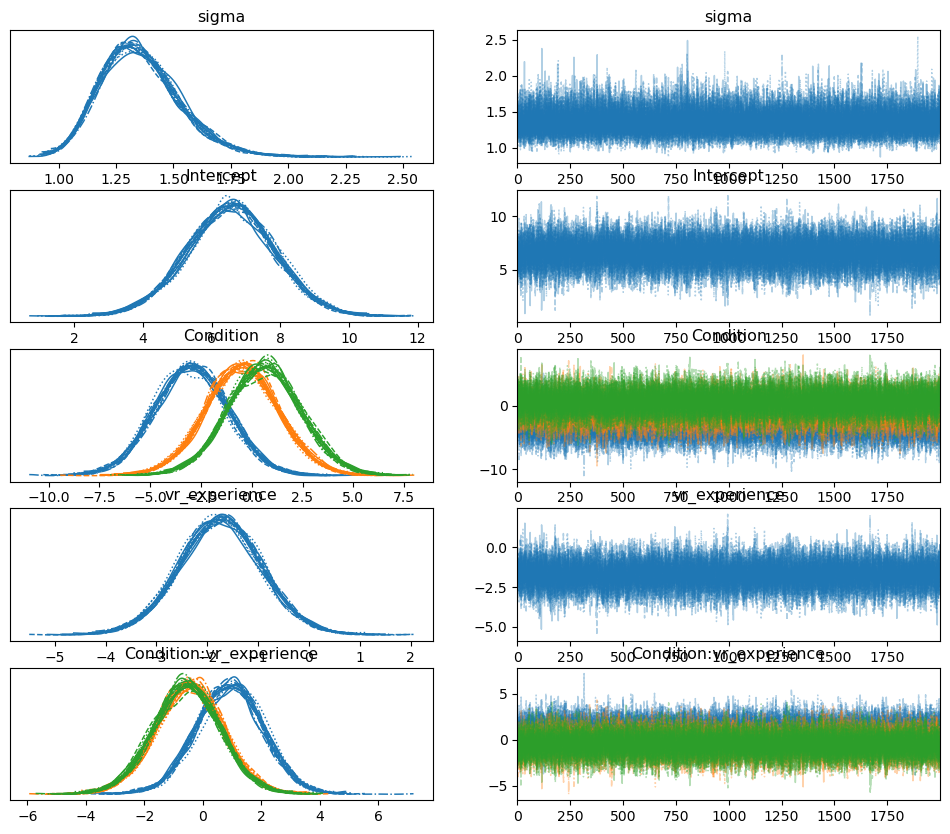

In [109]:
# Ergebnisse visualisieren

""" az.plot_trace(ownership_trace)
az.summary(ownership_trace, round_to=2)
plt.show()

az.plot_trace(agency_trace)
az.summary(agency_trace, round_to=2)
plt.show()"""
az.plot_trace(change_trace)
az.summary(change_trace, round_to=2)
plt.show()

c:\Users\LauflaborVR2\GS-MT_Test\.conda\Lib\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(
c:\Users\LauflaborVR2\GS-MT_Test\.conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


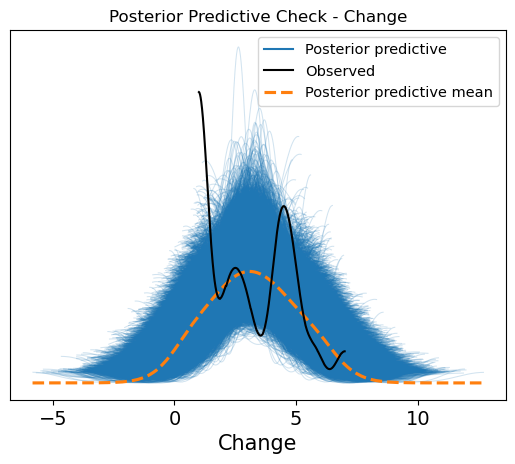

In [110]:
# Posterior Predictive Checks (PPC)
"""ownership_ppc = ownership_model.predict(idata=ownership_trace, kind="pps", inplace=False)
az.plot_ppc(ownership_ppc)
plt.title("Posterior Predictive Check - Ownership")
plt.show()

agency_ppc = agency_model.predict(idata=agency_trace, kind="pps", inplace=False)
az.plot_ppc(agency_ppc)
plt.title("Posterior Predictive Check - Agency")
plt.show()
"""
change_ppc = change_model.predict(idata=change_trace, kind="pps", inplace=False)
az.plot_ppc(change_ppc)
plt.title("Posterior Predictive Check - Change")
plt.show()